# Predicting and Analysing San Francisco Crimes

This notebook attempts to analysis and predict the class of crimes committed within the city of San Francisco. The code first exploring and visualising crime patterns across the neighbourhoods and police districts.

Then applying a machine learning algorithm in order to guess the category of the crimes based on their time and location of occurrence by using the Naive Bayes classifier as it's one of the simplest classification algorithms.

In [1]:
# load all the needed packages
import plotly
import numpy as np
import pandas as pd
import geopandas as gpd
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
from shapely.geometry import Point, Polygon, shape
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# plotly.tools.set_credentials_file(username='', api_key='')

In [2]:
# load dataset and parsing the dates column into datetime then join with the geodataframe later
train = pd.read_csv('train.csv', parse_dates = ['Dates'])
test = pd.read_csv('test.csv', parse_dates = ['Dates'])
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


As it well known that most machine learning algorithms can't support categorical data, so all categorical data should be converted into neumircal values. Pandas and scikit-learn provide several approaches to transform the text values into numeric values such as LabelEncoder and get_dummies. LabelEncoder is simply converting each text value in the column to a number whilst get_dummies creates dummy variables with a 1 or 0 corresponding to the correct value, very straightforward and one step procedure. LabelEncoder is not always a good choice since it brings a natural ordering or some sort of similarity for different crime classes.

In [3]:
# slice the Dates information into hours, days, months and years
train['Dates'] = pd.to_datetime(train['Dates'], format = "%m/%d/%Y %H:%M")
train['Hour'] = train['Dates'].dt.hour
train['Day'] = train['Dates'].dt.day
train['Month'] = train['Dates'].dt.month
train['Year'] = train['Dates'].dt.year
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Hour,Day,Month,Year
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,23,13,5,2015
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,23,13,5,2015
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,23,13,5,2015
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,23,13,5,2015
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,23,13,5,2015


In [4]:
# load neighbourhoods shapefile
nbhd_map = gpd.read_file('neighbourhoods/geo_export_b536bb6f-0837-4090-a495-c4d3c63feabe.shp')

In [5]:
# convert train to a geoDataFrame
train['Coords'] = train[['X', 'Y']].apply(tuple, axis = 1).apply(Point)
train = gpd.GeoDataFrame(train, geometry = 'Coords')
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Hour,Day,Month,Year,Coords
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,23,13,5,2015,POINT (-122.425891675136 37.7745985956747)
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,23,13,5,2015,POINT (-122.425891675136 37.7745985956747)
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,23,13,5,2015,POINT (-122.42436302145 37.8004143219856)
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,23,13,5,2015,POINT (-122.426995326766 37.80087263276921)
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,23,13,5,2015,POINT (-122.438737622757 37.77154117205779)


In [6]:
# map projections
train.crs = nbhd_map.crs

In [7]:
# merge the csv dataframes with the geodataframe
train = gpd.sjoin(nbhd_map, train)

In [8]:
# count the total number of incidents in a neighbourhood
total_incidents = train.nhood.value_counts()

In [9]:
# create a new column to include
nbhd_map = nbhd_map.merge(total_incidents.to_frame('total_incidents'), left_on = 'nhood', right_index = True)
nbhd_map.head()

,nhood,geometry,total_incidents
0,Bayview Hunters Point,POLYGON ((-122.3815777424142 37.75307043091241...,61292
1,Bernal Heights,"POLYGON ((-122.403612999828 37.74933700015653,...",18887
2,Castro/Upper Market,POLYGON ((-122.4265550005568 37.76948499984702...,23819
3,Chinatown,POLYGON ((-122.4062259995664 37.79755900029376...,13533
4,Excelsior,POLYGON ((-122.4239820002333 37.73155199975518...,17431


In [10]:
# use the neighbourhoods abbreviations for easier reading
abbreviations = ['Bayview', 'Brnl', 'Castro', 'ChTwn', 'Exclsr', 'FinDist', 'GlenPark', 'InRich', 'ggPark', 'Haight', 'Hayes', 'In_Sun', 'JpTwn', 'McLrn', 'TndrLn', 'LakeSh', 'Lncln', 'USF', 'Marina', 'Rus_Hill', 'Mission', 'MisBay', 'Nob', 'SeaClf', 'Noe', 'N_Beach', 'Inglsde', 'SoMA', 'Sunset/Parkside', 'Out_Mis', 'Out_Rich', 'Pcfc_Hts', 'Prtl', 'Potrero Hill', 'Presidio', 'Prsd_Hts', 'T_Isl', 'TwinPks', 'V_Val', 'WoTP', 'W_Add']
nbhd_map['abbr'] = abbreviations
nbhd_map.head()

,nhood,geometry,total_incidents,abbr
0,Bayview Hunters Point,POLYGON ((-122.3815777424142 37.75307043091241...,61292,Bayview
1,Bernal Heights,"POLYGON ((-122.403612999828 37.74933700015653,...",18887,Brnl
2,Castro/Upper Market,POLYGON ((-122.4265550005568 37.76948499984702...,23819,Castro
3,Chinatown,POLYGON ((-122.4062259995664 37.79755900029376...,13533,ChTwn
4,Excelsior,POLYGON ((-122.4239820002333 37.73155199975518...,17431,Exclsr


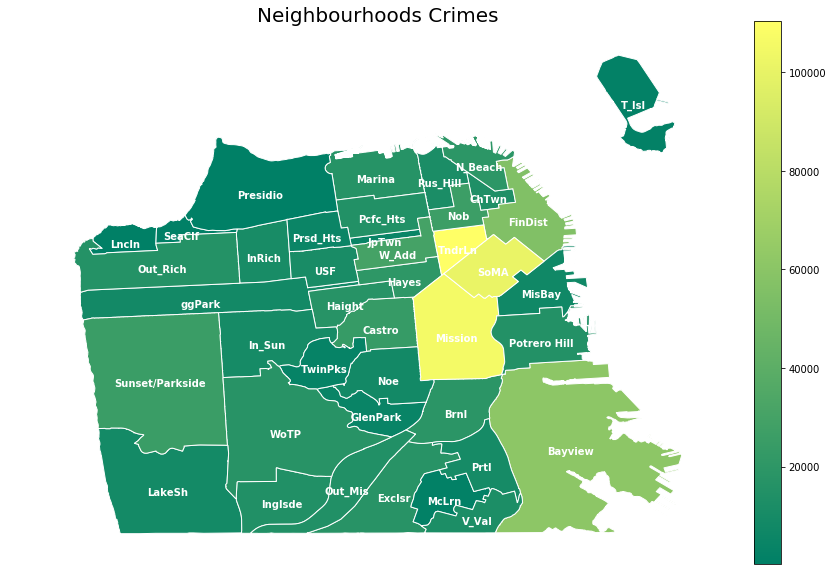

In [11]:
# create a map and colour it according to the total number of incidents
ax = nbhd_map.plot(column = 'total_incidents', cmap = 'summer', figsize = (15, 10), legend = True, linewidth = 1, edgecolor = 'white')
# remove the axis as maps look better without it
ax.axis('off')
# add a title
ax.set_title('Neighbourhoods Crimes', fontsize = 20, color = 'black')
# # label the neighbourhoods
for i in nbhd_map.index:
 coords = nbhd_map.geometry[i].centroid.coords[0]
 ax.annotate(s = nbhd_map['abbr'][i], xy = coords, horizontalalignment = 'center', verticalalignment = 'top', color = 'white', fontweight = 'heavy')

plt.savefig('neighbourhood_crimes.png', transparent = True)

In [12]:
# load police districts shapefile
police_dist_map = gpd.read_file('districts/geo_export_6015689b-ee79-4cf7-acfb-097881aaf1e7.shp')

In [13]:
# set district as index column
police_dist_geom = police_dist_map.set_index('district')

In [14]:
# count the number of incidents per police district
pd_incidents = train['PdDistrict'].value_counts()

In [15]:
# create a new column to include
police_dist_geom = police_dist_geom.merge(pd_incidents.to_frame('Incidents'), left_index = True, right_index = True)

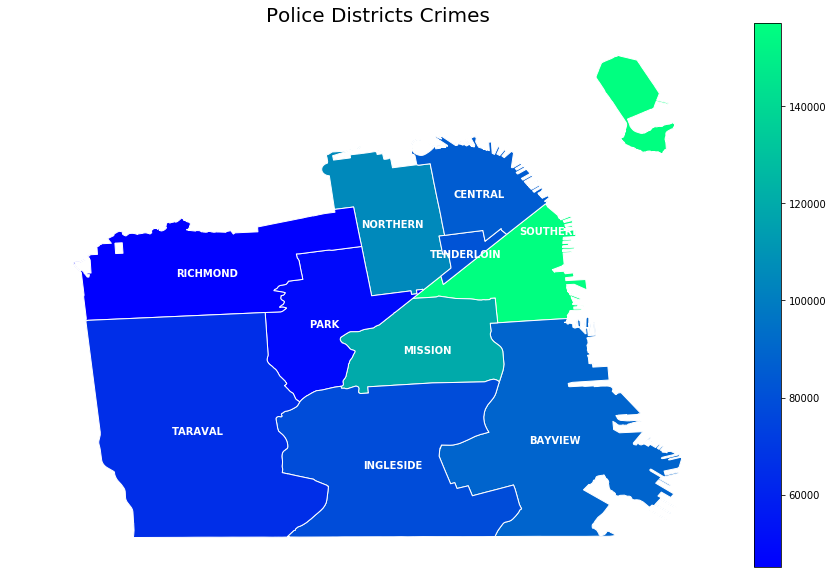

In [16]:
# create a map
ax2 = police_dist_geom.plot(column = 'Incidents', cmap = 'winter', figsize = (15,10), legend = True, linewidth = 1, edgecolor = 'white')
# customise the map
ax2.axis('off')
ax2.set_title('Police Districts Crimes', fontsize = 20, color = 'black')
for i in police_dist_geom.index:
    coords = police_dist_geom.geometry[i].centroid.coords[0]
    ax2.annotate(s = i, xy = coords, horizontalalignment = 'center', verticalalignment = 'top', color = 'white', fontweight = 'heavy')

plt.savefig('police_districts_crimes.png', transparent = True)

In [17]:
# extract all rows of street robberies using str.contains
street_robs = train[(train['Category'] == 'ROBBERY') & (train['Descript'].str.contains('STREET'))]

In [18]:
# count the total numbers of street robberies per neighbourhood
nbhd_st_rob_incdts = street_robs.nhood.value_counts()
# create a new column to include
nbhd_map = nbhd_map.merge(nbhd_st_rob_incdts.to_frame('st_rob_incdts'), left_on = 'nhood', right_index = True)

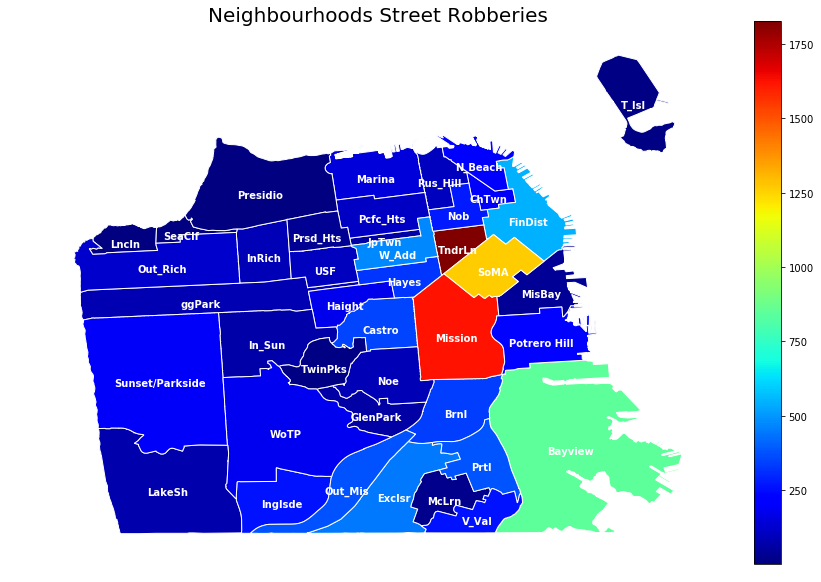

In [19]:
# create a map
ax3 = nbhd_map.plot(column = 'st_rob_incdts', cmap = 'jet', figsize = (15,10), legend = True, linewidth = 1, edgecolor = 'white')
# customise the map
ax3.axis('off')
ax3.set_title('Neighbourhoods Street Robberies', fontsize = 20, color = 'black')
for i in nbhd_map.index:
    coords = nbhd_map.geometry[i].centroid.coords[0]
    ax3.annotate(s = nbhd_map['abbr'][i], xy = coords, horizontalalignment = 'center', verticalalignment = 'top', color = 'white', fontweight = 'heavy')

plt.savefig('neighbourhood_robberies.png', transparent = True)

The Eastern neighbourhoods experience a higher rate of street robberies.

In [20]:
# explore methods of street robberies
methods = street_robs['Descript'].value_counts()
method_labels = methods.index
method_values = methods

pie_methods = go.Pie(labels = method_labels, values = method_values, hoverinfo = 'label+percent', textinfo = 'value', hole = 0.67, rotation = 160)
data = [pie_methods]
layout = go.Layout(height = 650, showlegend = False, title = dict(text='Methods of <br> Street Robberies', x = 0.5, y = 0.5, font = dict(size = 23)))
fig = go.Figure(data, layout = layout)
py.iplot(fig)

So the above chart shows that strongarm robberies make about 56% of the cromes followed by gun robberies about 17.4% and bodily force with 9.55%.

In [21]:
# explore the dialy trends within each neighborhood
neighbourhoods = pd.unique(street_robs['nhood'])
days = {'Monday':'Mon', 'Tuesday':'Tue', 'Wednesday':'Wed', 'Thursday':'Thur', 'Friday':'Fri', 'Saturday':'Sat', 'Sunday':'Sun'}
data = []
for i in range(len(neighbourhoods)):
    trace = go.Histogram(
        x = street_robs[street_robs['nhood'] == neighbourhoods[i]].sort_values('DayOfWeek')['DayOfWeek'].map(days),
        opacity = 0.7, name = neighbourhoods[i],
    )
    data.append(trace)
layout = go.Layout(
    title = 'Daily Incidence of Street Robberies',
    barmode = 'overlay'
)
fig = go.Figure(data, layout)
py.iplot(fig)

You can click the legend buttons to toggle viewing, also bars are stacked to show total number of incidents, yet the crime rate on weekends (Friday night and Saturday night) falls shortly and increases again.

In [22]:
# explore hourly trends across neighbourhoods
neighbourhoods = pd.unique(street_robs['nhood'])
data = []

for i in range(len(neighbourhoods)):
    nbhd_hours = street_robs[street_robs['nhood'] == neighbourhoods[i]]['Hour'].value_counts()
    trace = go.Bar(
        x = nbhd_hours.index,
        y = nbhd_hours,
        opacity = 0.7,
        name = neighbourhoods[i],
    )
    data.append(trace)
layout = go.Layout(
    title = 'Hourly Incidence of Street Robberies',
    barmode = 'stack',
    xaxis = dict(dtick = 1),
    )
fig = go.Figure(data, layout)
py.iplot(fig)

The above chart shows that the crime rate is significantly higher after sunset and before sunrise and and decreases as the time passes.

To view a fully interactive version of this jupyter notebook file (or to view the above three plots with javascript content rendered in other words), you can use nbviewer to render it as static web page by simply copying the url of this page and pasting it straight into the hyperlink bar of [nbviewer](https://nbviewer.jupyter.org).

# Machine Learning

## Predicting the category of San Francisco crimes:

In [23]:
# encode crime categories
le = preprocessing.LabelEncoder()
category = le.fit_transform(train['Category'])

In [24]:
# encode weekdays, districts and hours
district = pd.get_dummies(train['PdDistrict'])
days = pd.get_dummies(train['DayOfWeek'])
hour = train['Dates'].dt.hour
hour = pd.get_dummies(hour)

In [25]:
# pass encoded values to a new dataframe
enc_train = pd.concat([hour, days, district], axis = 1)
enc_train['Category'] = category

In [26]:
# add gps coordinates
enc_train['X'] = train['X']
enc_train['Y'] = train['Y']

In [27]:
# repeat data handling for test data by encoding weekdays, districts and hours
district = pd.get_dummies(test['PdDistrict'])
days = pd.get_dummies(test['DayOfWeek'])
hour = test['Dates'].dt.hour
hour = pd.get_dummies(hour)

In [28]:
# create a new dataframe for encoded test values
enc_test = pd.concat([hour, days, district], axis = 1)

In [29]:
# add gps coordinates
enc_test['X'] = test['X']
enc_test['Y'] = test['Y']

Next step is to split up the enc_train into a training and validation set so that we there's a way to access the model performance without touching the test data.

In [30]:
training, validation = train_test_split(enc_train, train_size = 0.60)

In [31]:
features = ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN', 'X', 'Y']
# add the time to the feature
features.extend(x for x in range(0,24))

In [32]:
model = BernoulliNB()
model.fit(training[features], training['Category'])
predicted = np.array(model.predict_proba(validation[features]))
log_loss(validation['Category'], predicted)

2.5822672361646988

In [33]:
# now let's see what log_loss score we get if we apply LogisticRegression
model = LogisticRegression(C = 0.01)
model.fit(training[features], training['Category'])
predicted = np.array(model.predict_proba(validation[features]))
log_loss(validation['Category'], predicted)

2.584027578120877

log_loss or logarithmic loss is a classification metric based on probabilities where it quantifies the accuracy of a classifier by penalising false classifications, in other words minimising the log_loss means maximising the accuracy and lower log-loss value makes better predictions. Also LogisticRegression took 71.93 secs to run, while BernoulliNB took only 2.65 secs.

In [34]:
model = BernoulliNB()
model.fit(enc_train[features], enc_train['Category'])
predicted = model.predict_proba(enc_test[features])

In [35]:
# extract results
result = pd.DataFrame(predicted, columns = le.classes_)
result.to_csv('results.csv', index = True, index_label = 'Id')

However Naive Bayes is a fairly simple model, it can give great results!